In [96]:
# General
import numpy as np
import pandas as pd

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# Modeling
import statsmodels.api as sm

#NLP
import nltk
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [101]:
def CleanCSV():
    
    # Read and Peak at Data
    df = pd.read_csv("Womens_Clothing_Reviews.csv")
    df.drop(df.columns[0],inplace=True, axis=1)

    # Delete missing observations for following variables
    df = df[df.notnull()]
    

    # Data Dimensions
    print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))
    return (df)
    

In [102]:
df = CleanCSV()
df.head()
key = "Class Name"
temp = (df.groupby(key)[["Rating","Recommended IND", "Age"]]
        .aggregate(['count','mean']))
temp.columns = ["Count","Rating Mean","Recommended Likelihood Count",
                "Recommended Likelihood","Age Count","Age Mean"]
temp.drop(["Recommended Likelihood Count","Age Count"], axis=1, inplace =True)

Dataframe Dimension: 23486 Rows, 10 Columns


In [103]:
# Simple Linear Regression Model
model_fit = sm.OLS(temp["Recommended Likelihood"],
               sm.add_constant(temp["Age Mean"])).fit() 
temp['resid'] = model_fit.resid

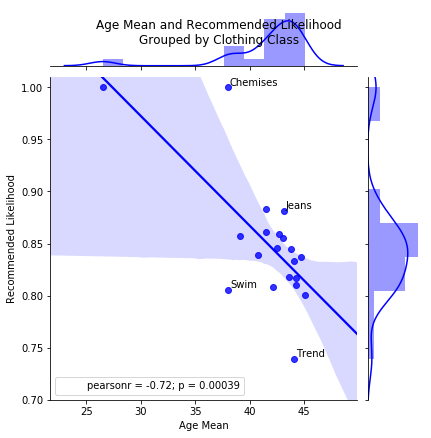

,Count,Rating Mean,Recommended Likelihood,Age Mean,resid
Class Name,,,,,
Casual bottoms,2,4.5,1.0,26.5,-0.009266
Chemises,1,4.0,1.0,38.0,0.111798


In [59]:
# Plot
g = sns.jointplot(y="Recommended Likelihood",x='Age Mean',data=temp,
                  kind='reg', color='b')
plt.subplots_adjust(top=0.999)
g.fig.suptitle("Age Mean and Recommended Likelihood\nGrouped by Clothing Class")
plt.ylim(.7, 1.01)

# Annotate Outliers
head = temp.sort_values(by=['resid'], ascending=[False]).head(2)
tail = temp.sort_values(by=['resid'], ascending=[False]).tail(2)

def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=( r["Age Mean"], r["Recommended Likelihood"]), 
            xytext=(2,2) , textcoords ="offset points", )

for row in head.iterrows():
    ann(row)
for row in tail.iterrows():
    ann(row)

plt.show()
del head, tail

temp[temp["Recommended Likelihood"] > .95]

In [60]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Recommended Likelihood   R-squared:                       0.513
Model:                                OLS   Adj. R-squared:                  0.485
Method:                     Least Squares   F-statistic:                     18.93
Date:                    Mon, 07 May 2018   Prob (F-statistic):           0.000385
Time:                            13:31:22   Log-Likelihood:                 35.341
No. Observations:                      20   AIC:                            -66.68
Df Residuals:                          18   BIC:                            -64.69
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2882      0.101     12.724      0.000       1.076       1.501
Age Mean      -0.0105      0.002     -4.351      0.000      -0.016      -0.005
==============================================================================
Omnibus:                        3.822   Durbin-Watson:                   1.698
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                2.041
Skew:                           0.237   Prob(JB):                        0.360
Kurtosis:                       4.491   Cond. No.                         435.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
def WordCount():
    
    
    # Read and Peak at Data
    df = CleanCSV()
    df.drop(df.columns[0],inplace=True, axis=1)

    # Delete missing observations for following variables
    for x in ["Division Name","Department Name","Class Name","Review Text"]:
        df = df[df[x].notnull()]

    # Extracting Missing Count and Unique Count by Column
    unique_count = []
    for x in df.columns:
        unique_count.append([x,len(df[x].unique()),df[x].isnull().sum()])

    # Missing Values
    print("Missing Values: {}".format(df.isnull().sum().sum()))
    #print (pd.DataFrame(unique_count, columns=["Column","Unique","Missing"]).set_index("Column").T)

    # Data Dimensions
    print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))

    # Create New Variables: 
    # Word Length
    df["Word Count"] = df['Review Text'].str.split().apply(len)
    # Character Length
    df["Character Count"] = df['Review Text'].apply(len)
    # Boolean for Positive and Negative Reviews
    df["Label"] = 0
    df.loc[df.Rating >= 3,["Label"]] = 1
    return
test = WordCount()


Dataframe Dimension: 23486 Rows, 10 Columns
Missing Values: 2966
Dataframe Dimension: 22628 Rows, 9 Columns


In [62]:
df.describe().T.drop("count",axis=1)

,mean,std,min,25%,50%,75%,max
Clothing ID,918.118709,203.298980,0.0,861.0,936.0,1078.0,1205.0
Age,43.198544,12.279544,18.0,34.0,41.0,52.0,99.0
Rating,4.196032,1.110031,1.0,4.0,5.0,5.0,5.0
Recommended IND,0.822362,0.382216,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,2.535936,5.702202,0.0,0.0,1.0,3.0,122.0


In [63]:
df[["Title", "Division Name","Department Name","Class Name"]].describe(include=["O"]).T.drop("count",axis=1)

,unique,top,freq
Title,13993,Love it!,136
Division Name,3,General,13850
Department Name,6,Tops,10468
Class Name,20,Dresses,6319


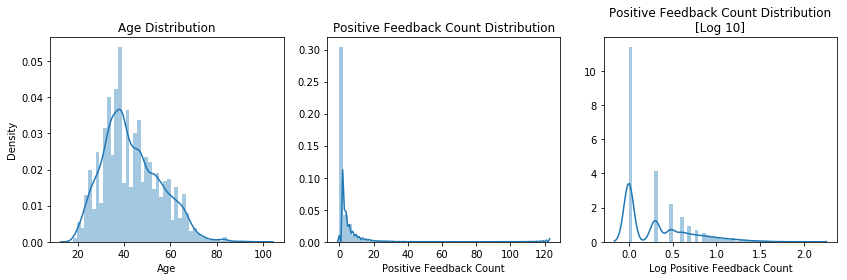

In [64]:
#Age and Positive Feedback Count Distributions:
# Continous Distributions
f, ax = plt.subplots(1,3,figsize=(12,4), sharey=False)
sns.distplot(df.Age, ax=ax[0])
ax[0].set_title("Age Distribution")
ax[0].set_ylabel("Density")
sns.distplot(df["Positive Feedback Count"], ax=ax[1])
ax[1].set_title("Positive Feedback Count Distribution")
sns.distplot(np.log10((df["Positive Feedback Count"][df["Positive Feedback Count"].notnull()]+1)), ax=ax[2])
ax[2].set_title("Positive Feedback Count Distribution\n[Log 10]")
ax[2].set_xlabel("Log Positive Feedback Count")
plt.tight_layout()
plt.show()

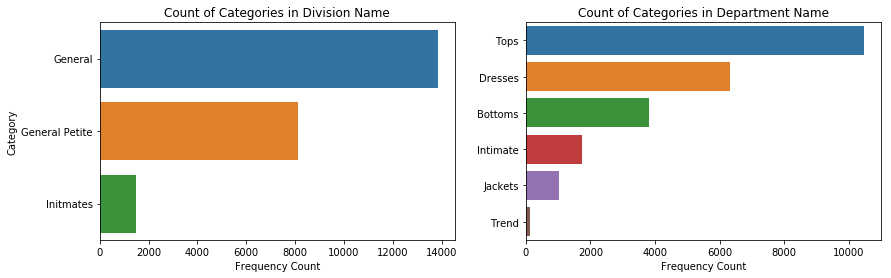

In [65]:
#Division Name and Department Name Distribution:
row_plots = ["Division Name","Department Name"]
f, axes = plt.subplots(1,len(row_plots), figsize=(14,4), sharex=False)

for i,x in enumerate(row_plots):
    sns.countplot(y=x, data=df,order=df[x].value_counts().index, ax=axes[i])
    axes[i].set_title("Count of Categories in {}".format(x))
    axes[i].set_xlabel("")
    axes[i].set_xlabel("Frequency Count")
axes[0].set_ylabel("Category")
axes[1].set_ylabel("")
plt.show()

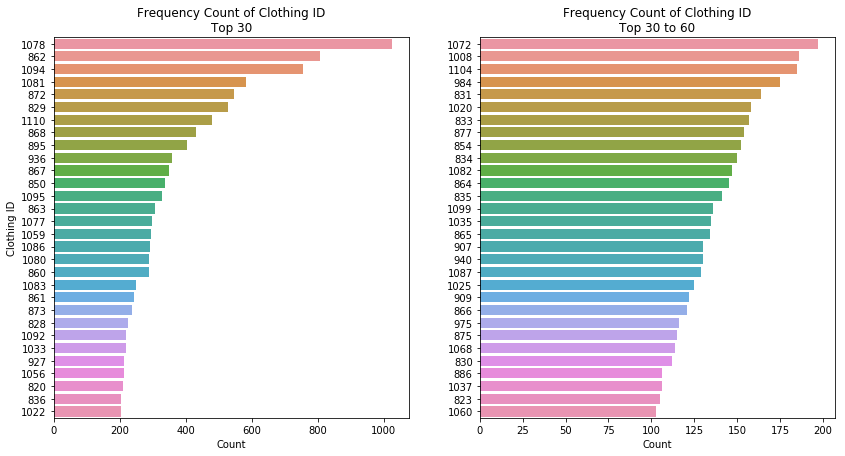

Dataframe Dimension: 23486 Rows


,mean,std,min,25%,50%,75%,max
Clothing ID,1015.354988,103.422628,862.0,862.0,1078.0,1094.0,1094.0
Age,42.631090,12.110996,18.0,34.0,41.0,50.0,99.0
Rating,4.198763,1.099646,1.0,4.0,5.0,5.0,5.0
Recommended IND,0.820959,0.383461,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,2.767208,6.679159,0.0,0.0,1.0,3.0,98.0


In [66]:
#Distribution of Clothing ID to Understand Product Popularity
# Clothing ID Category
f, axes = plt.subplots(1,2, figsize=[14,7])
num = 30
sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[:num].index)],
              order= df["Clothing ID"].value_counts()[:num].index, ax=axes[0])
axes[0].set_title("Frequency Count of Clothing ID\nTop 30")
axes[0].set_xlabel("Count")

sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[num:60].index)],
              order= df["Clothing ID"].value_counts()[num:60].index, ax=axes[1])
axes[1].set_title("Frequency Count of Clothing ID\nTop 30 to 60")
axes[1].set_ylabel("")
axes[1].set_xlabel("Count")
plt.show()

print("Dataframe Dimension: {} Rows".format(df.shape[0]))
df[df["Clothing ID"].isin([1078, 862,1094])].describe().T.drop("count",axis=1)

In [67]:
df.loc[df["Clothing ID"].isin([1078, 862,1094]),
       ["Title", "Division Name","Department Name","Class Name"]].describe(include=["O"]).T.drop("count",axis=1)

,unique,top,freq
Title,1815,Beautiful dress,21
Division Name,2,General,1572
Department Name,2,Dresses,1780
Class Name,2,Dresses,1780


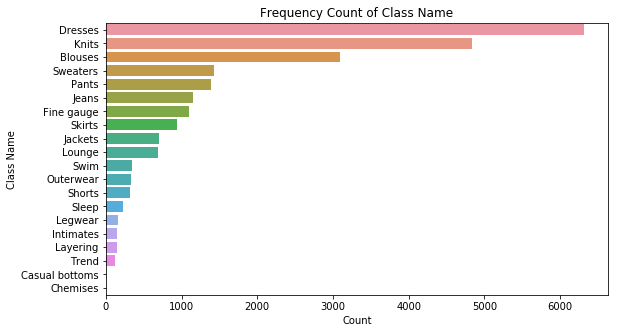

In [68]:
#distribution class name
# Class Name
plt.subplots(figsize=(9,5))
sns.countplot(y="Class Name", data=df,order=df["Class Name"].value_counts().index)
plt.title("Frequency Count of Class Name")
plt.xlabel("Count")
plt.show()

In [69]:
#lets start working with text
#text pre-processing
pd.set_option('max_colwidth', 500)
df[["Title","Review Text", "Rating"]].sample(10)

,Title,Review Text,Rating
21572,"Vivid print, easy fit",This will be a frequently worn item. print is beautiful and the fit is comfy and classy.,5
4555,Beautiful softness,"This shirt has an incredible softness to it and the purple print is so lovely, i did end up returning it simply because the flowiness was a bit too much for me. i had tried the 2 and 4 and went with the 4 due to arm restrictions in the smaller size. too bad because it really is a lovely top. definitely worth a try in store!",4
5421,Fun t,"This is just as cute in person. i wear it with black jean shorts, boyfriend jeans, washed out jeans like the model, or khakis. the colors are great and so is the fit. love it.",5
4693,Unflattering,"As someone with a large chest and a smaller waist, i found this top incredibly unflattering (and i like swingy tops). it was too short, too wide in the hips, and too tight in the bust. the pattern and fabric are very pretty though.",2
8146,"Strange, unflattering fit","This top did nothing for me. it billowed in the front and was not flattering. for reference, i am 5""4, 115 pounds, and small chested. i ordered the smallest size the top came in (cannot recall if it was an xs or 0). i promptly returned it.",2
2131,NaN,"I love everything about this top! the fabric, the color, the fit! great top for spring and summer!",5
759,Perfect dress,"I wasn't going to purchase this dress because it was given 1 star. however, i ordered it and i was so glad i did!!! i'm 5'1, 105lbs this dress fit me perfectly, it really compliment my petite body. i get so much compliments! it is not easy to order anything for a petite frame but this dress really show off my body without showing too much.",5
9848,"Potential, but sizing is inconsistent","Ordered these in two colors( moss and bronze), same size (26). the moss fit perfectly and the bronze, i can't even button. so very frustrating, particularly when shipping fees are involved. i'm keeping the pair that fit but was hoping to have a couple pairs. perhaps i'll try on another pair in the store. its a nice lean slimming pant that will work from fall through spring. the material is a bit thick for summer. soft and a tad stretchy to allow ease of movement. looking forward to wearing with",3
8396,Compliments galore!,Love this so much. it's beautiful and i get tons of compliments. it's a touch short as a dress but looks amazing with leggings!,5
9500,Keeper!,Love the muted orange color and the design. it's lightweight and will be perfect for fall days!,5


'''
Code Explanation: 
This chunk of code creates a function that takes each review and combines them into one seamless text. 
It then applies lowercase, tokenizer, removes stopwords and punctuation, and finally uses the PorterStemmer.
Sentimental analysis
Lets understand the customer reviews to see how the textual sentiment relates to the rating scores. 
With this method, it will be possible to distinguish outright positive and negative comments from the 
constructive variant
'''

In [70]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
#ps = LancasterStemmer()
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    #words = [ps.stem(w) for w in words] #4
    return words

In [71]:
# Pre-Processing
SIA = SentimentIntensityAnalyzer()
df["Review Text"]= df["Review Text"].astype(str)

# Applying Model, Variable Creation
df['Polarity Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['compound'])
df['Neutral Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neu'])
df['Negative Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neg'])
df['Positive Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['pos'])

# Converting 0 to 1 Decimal Score to a Categorical Variable
df['Sentiment']=''
df.loc[df['Polarity Score']>0,'Sentiment']='Positive'
df.loc[df['Polarity Score']==0,'Sentiment']='Neutral'
df.loc[df['Polarity Score']<0,'Sentiment']='Negative'

In [72]:
def percentstandardize_barplot(x,y,hue, data, ax=None, order= None):
    """
    Standardize by percentage the data using pandas functions, then plot using Seaborn.
    Function arguments are and extention of Seaborns'.
    """
    sns.barplot(x= x, y=y, hue=hue, ax=ax, order=order,
    data=(data[[x, hue]]
     .reset_index(drop=True)
     .groupby([x])[hue]
     .value_counts(normalize=True)
     .rename('Percentage').mul(100)
     .reset_index()
     .sort_values(hue)))
    plt.title("Percentage Frequency of {} by {}".format(hue,x))
    plt.ylabel("Percentage %")

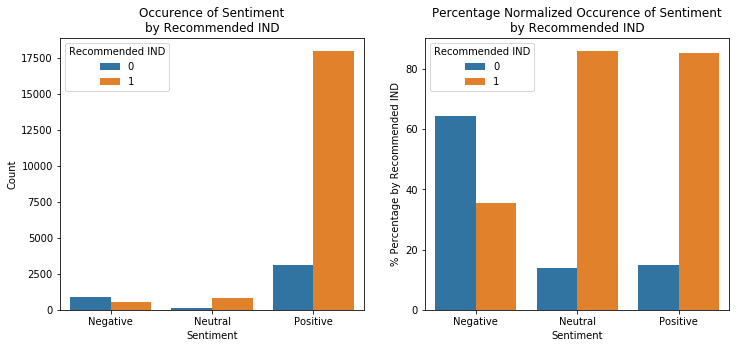

In [73]:
huevar = "Recommended IND"
xvar = "Sentiment"
f, axes = plt.subplots(1,2,figsize=(12,5))
sns.countplot(x=xvar, hue=huevar,data=df, ax=axes[0], order=["Negative","Neutral","Positive"])
axes[0].set_title("Occurence of {}\nby {}".format(xvar, huevar))
axes[0].set_ylabel("Count")
percentstandardize_barplot(x=xvar,y="Percentage", hue=huevar,data=df, ax=axes[1])
axes[1].set_title("Percentage Normalized Occurence of {}\nby {}".format(xvar, huevar))
axes[1].set_ylabel("% Percentage by {}".format(huevar))
plt.show()

In [74]:
def percentstandardize_barplot(x,y,hue, data, ax=None, order= None):
    """
    Standardize by percentage the data using pandas functions, then plot using Seaborn.
    Function arguments are and extention of Seaborns'.
    """
    sns.barplot(x= x, y=y, hue=hue, ax=ax, order=order,
    data=(data[[x, hue]]
     .reset_index(drop=True)
     .groupby([x])[hue]
     .value_counts(normalize=True)
     .rename('Percentage').mul(100)
     .reset_index()
     .sort_values(hue)))
    plt.title("Percentage Frequency of {} by {}".format(hue,x))
    plt.ylabel("Percentage %")

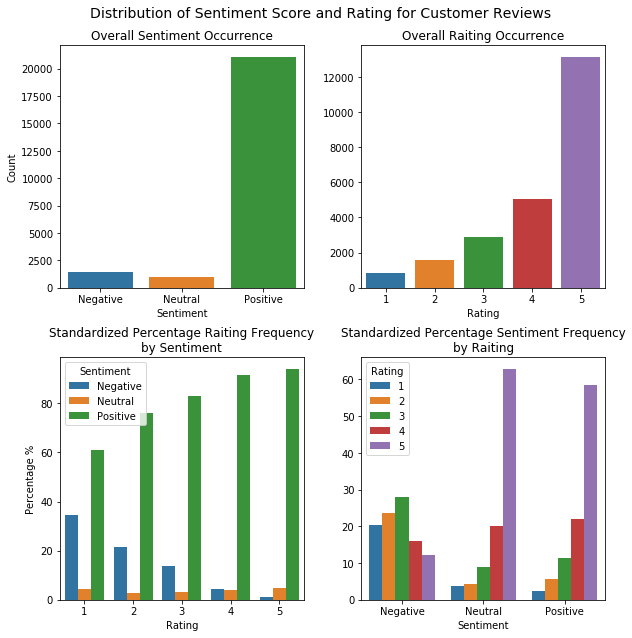

In [75]:
#Interpretation: 
#Recommended is a variable that clearly indicates positive sentiment in the review.
f, axes = plt.subplots(2,2, figsize=[9,9])
sns.countplot(x="Sentiment", data=df, ax=axes[0,0], order=["Negative","Neutral","Positive"])
axes[0,0].set_xlabel("Sentiment")
axes[0,0].set_ylabel("Count")
axes[0,0].set_title("Overall Sentiment Occurrence")

sns.countplot(x="Rating", data=df, ax=axes[0,1])
axes[0,1].set_xlabel("Rating")
axes[0,1].set_ylabel("")
axes[0,1].set_title("Overall Raiting Occurrence")

percentstandardize_barplot(x="Rating",y="Percentage",hue="Sentiment",data=df, ax=axes[1,0])
axes[1,0].set_xlabel("Rating")
axes[1,0].set_ylabel("Percentage %")
axes[1,0].set_title("Standardized Percentage Raiting Frequency\nby Sentiment")

percentstandardize_barplot(x="Sentiment",y="Percentage",hue="Rating",data=df, ax=axes[1,1])
axes[1,1].set_ylabel("Occurrence Frequency")
axes[1,1].set_title("Standardized Percentage Sentiment Frequency\nby Raiting")
axes[1,1].set_xlabel("Sentiment")
axes[1,1].set_ylabel("")

f.suptitle("Distribution of Sentiment Score and Rating for Customer Reviews", fontsize=14)
f.tight_layout()
f.subplots_adjust(top=0.92)
plt.show()

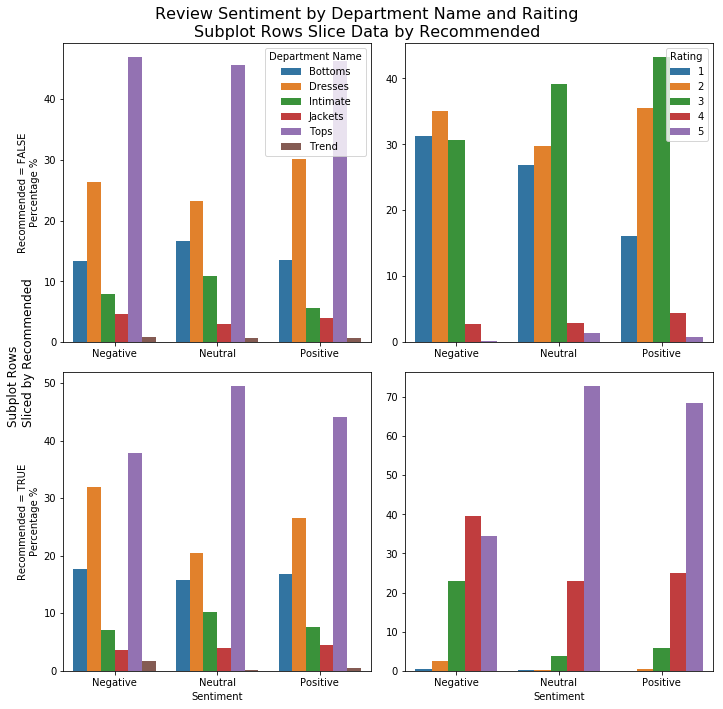

In [76]:
#Visualization, plots the frequency of sentiments in a bar plot using matplotlib.
# Tweakable Variables (Note to Change Order Arguement if Xvar is changed)
xvar = "Sentiment"
huevar = "Department Name"
rowvar = "Recommended IND"

# Plot
f, axes = plt.subplots(2,2,figsize=(10,10), sharex=False,sharey=False)
for i,x in enumerate(set(df[rowvar][df[rowvar].notnull()])):
    percentstandardize_barplot(x=xvar,y="Percentage", hue=huevar,data=df[df[rowvar] == x],
                 ax=axes[i,0], order=["Negative","Neutral","Positive"])
    percentstandardize_barplot(x=xvar,y="Percentage", hue="Rating",data=df[df[rowvar] == x],
                 ax=axes[i,1], order=["Negative","Neutral","Positive"])

# Plot Aesthetics
axes[1,0].legend_.remove()
axes[1,1].legend_.remove()
axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")
axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[0,0].set_ylabel("Recommended = FALSE\nPercentage %")
axes[1,0].set_ylabel("Recommended = TRUE\nPercentage %")
axes[1,1].set_title("")

# Common title and ylabel
f.text(0.0, 0.5, 'Subplot Rows\nSliced by Recommended', va='center', rotation='vertical', fontsize=12)
f.suptitle("Review Sentiment by Department Name and Raiting\nSubplot Rows Slice Data by Recommended", fontsize=16)
f.tight_layout()
f.subplots_adjust(top=0.93)
plt.show()

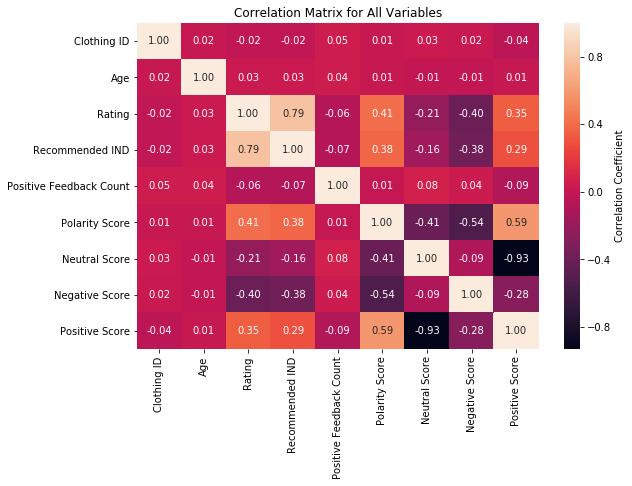

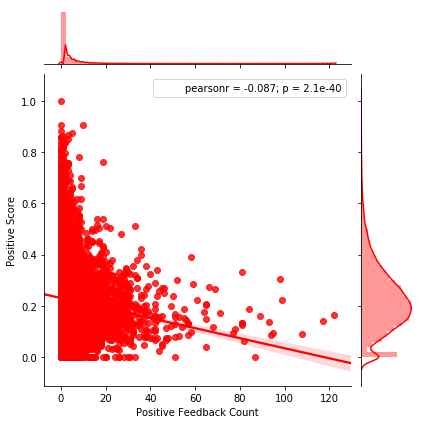

In [77]:
'''
How to Interpret: 
In this plot, the upper and lower rows use the same variables, but the upper row is for non-recommended reviews, 
while the bottom row is for recommended reviews. This enables use to explore the nature of recommended reviews 
in terms of the mood of the writing, as well as the rating assigned by the customer.
'''
# Plot Correlation Matrix
f, ax = plt.subplots(figsize=[9,6])
ax = sns.heatmap(df.corr(), annot=True,
                 fmt=".2f",cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title("Correlation Matrix for All Variables")
plt.show()

# Sentiment Positivity Score by Positive Feedback Count
ax = sns.jointplot(x= df["Positive Feedback Count"], y=df["Positive Score"], kind='reg', color='r')
plt.show()

In [78]:
#lets start looking at Word Distribution and Word Cloud 
from nltk.corpus import stopwords
from pyspark.ml.feature import StopWordsRemover
import re
import nltk
nltk.download('stopwords')

stopwords = set(stop_words)
size = (20,10)

def cloud(text, title, stopwords=stopwords, size=size):
    """
    Function to plot WordCloud
    Includes: 
    """
    # Setting figure parameters
    mpl.rcParams['figure.figsize']=(10.0,10.0)
    mpl.rcParams['font.size']=12
    mpl.rcParams['savefig.dpi']=100
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    # Processing Text
    # Redundant when combined with my Preprocessing function
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords=stopwords,
                         ).generate(str(text))
    
    # Output Visualization
    fig = plt.figure(figsize=size, facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()
    
# Frequency Calculation [One-Gram]
def wordfreqviz(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    matplotlib.style.use('ggplot')
    rslt.plot.bar(rot=0)

def wordfreq(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    return rslt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nkulkar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


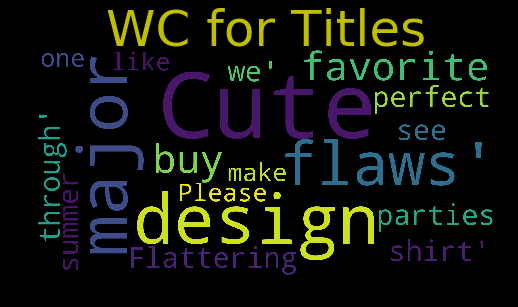

In [79]:
# Modify Stopwords to Exclude Class types, suchs as "dress"
#Lets visualize titles

from wordcloud import WordCloud

new_stop = set(stop_words)
new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                + ["dress", "petite"])

# Cloud
cloud(text= df.Title[df.Title.notnull()].astype(str).values,
      title="WC for Titles",
      stopwords= new_stop,
      size = (7,4))

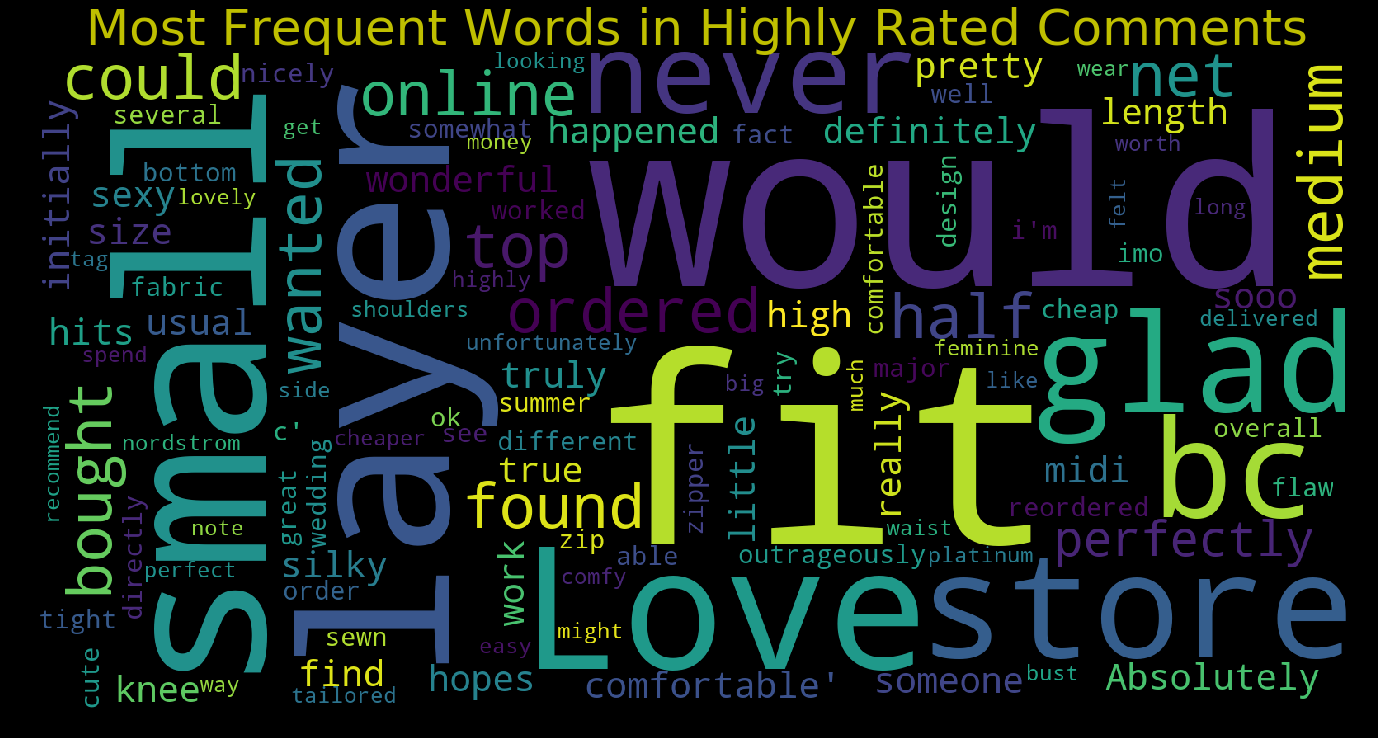

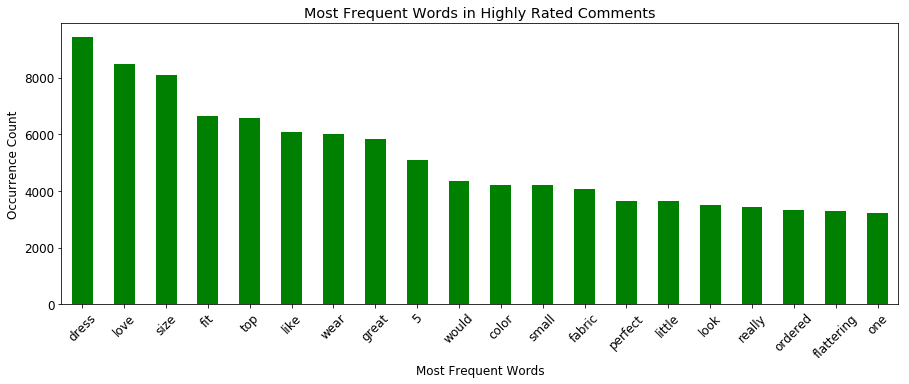

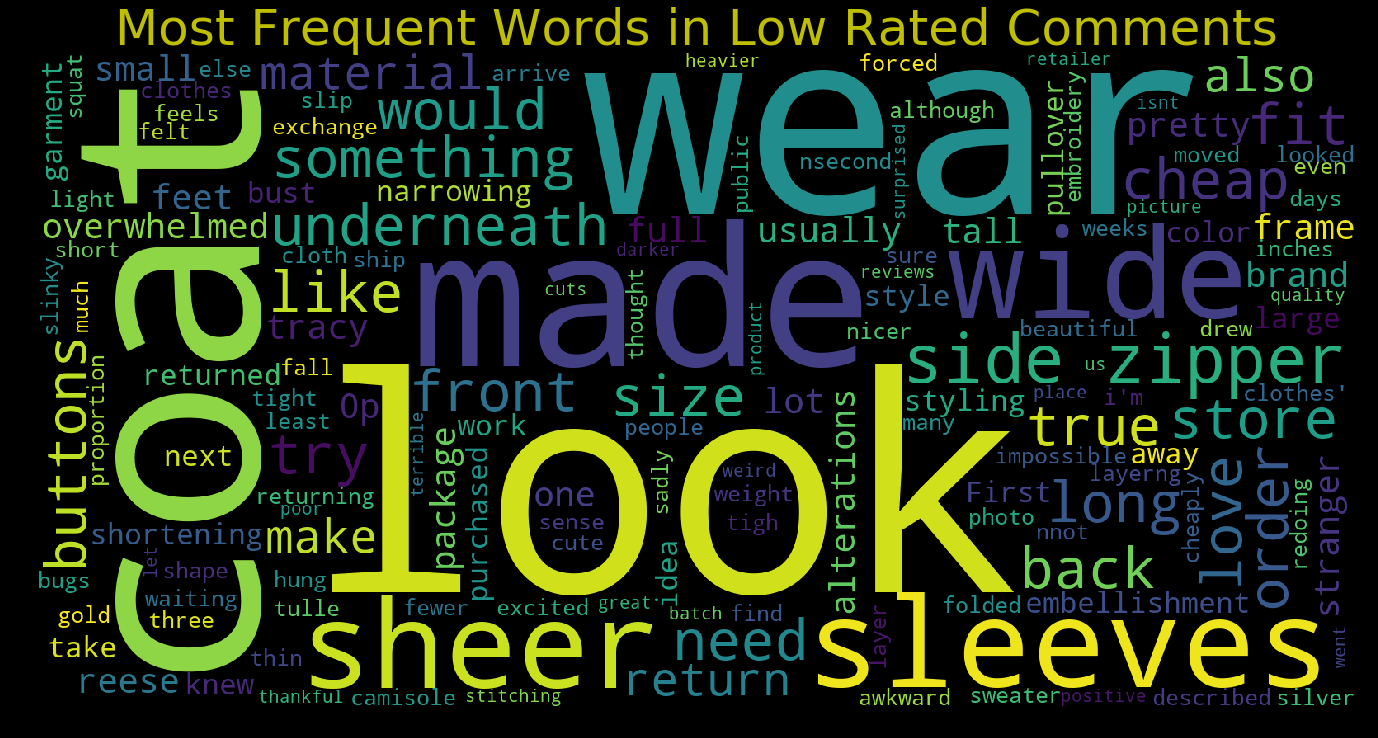

In [80]:
#Now lets visualize titles
# Highly Raited
title ="Most Frequent Words in Highly Rated Comments"
temp = df['Review Text'][df.Rating.astype(int) >= 3]

# Modify Stopwords to Exclude Class types, suchs as "dress"
new_stop = set(stop_words)
new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                + ["dress", "petite"])

# Cloud
cloud(text= temp.values, title=title,stopwords= new_stop)

# Bar Chart
wordfreq(preprocessing(temp),20).plot.bar(rot=45, legend=False,figsize=(15,5), color='g',
                          title= title)
plt.ylabel("Occurrence Count")
plt.xlabel("Most Frequent Words")
plt.show()

# Low Raited
title ="Most Frequent Words in Low Rated Comments"
temp = df['Review Text'][df.Rating.astype(int) < 3]

# Modify Stopwords to Exclude Class types, suchs as "dress"
new_stop = set(stop_words)
new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                + ["dress", "petite", "skirt","shirt"])

# Cloud
cloud(temp.values, title= title, stopwords = new_stop)

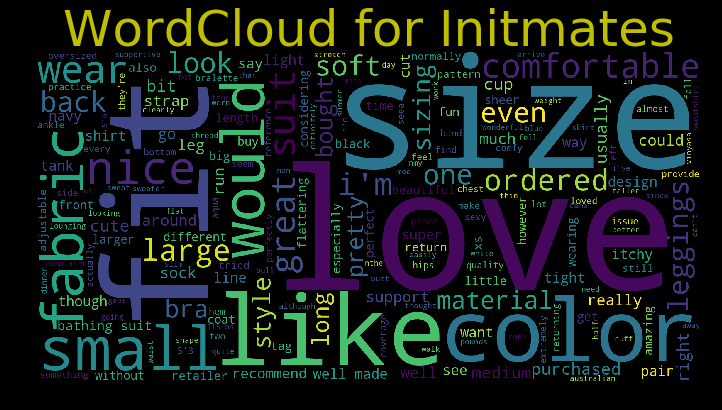

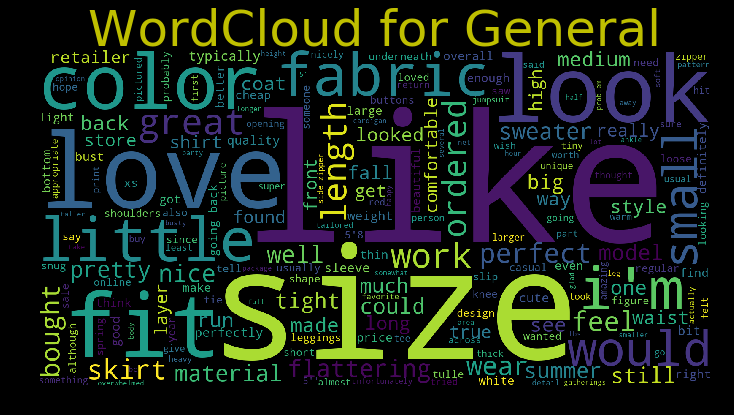

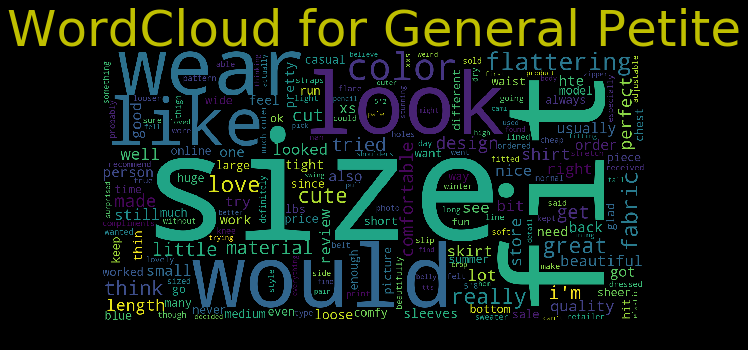

In [81]:
#Now lets  WordClouds by Department Name 
#A Wordcloud (or Tag cloud) is a visual representation of text data. 
#It displays a list of words, the importance of each beeing shown with font size or color.



department_set = df["Department Name"][df["Department Name"].notnull()].unique()
division_set = df["Division Name"][df["Division Name"].notnull()].unique()
def cloud_by_category(data, category, subclass):
    """
    Function to create a wordcloud by class and subclass
    Category signifies the column variable
    Subclass refers to the specific value within the categorical variable
    """
    new_stop = set(stop_words)
    new_stop.update([x.lower() for x in list(data["Class Name"][data["Class Name"].notnull()].unique())]
                   + [x.lower() for x in list(data["Department Name"][data["Department Name"].notnull()].unique())]
                   + ["dress", "petite", "jacket","top"])

    # Cloud
    cloud(text= data["Review Text"][data[category]== subclass],
          title="WordCloud for {}".format(subclass),
          stopwords= new_stop,
          size = (10,6))
    
# Plot
cloud_by_category(df, "Division Name", division_set[0])
cloud_by_category(df, "Division Name", division_set[1])
cloud_by_category(df, "Division Name", division_set[2])

In [82]:
#N Grams by Recommended Feature
'''
The central themes in the product reviews brought to light by the n-grams are:

Fit: Whether the product’s advertised size actually corresponds to customer size and height.
Love or Hate: The customer's personal feelings towards the product.
Complements: The customer's social experience wearing the product.
Product consistency: Whether the product appears as advertised, lives up to quality expectations.
'''
## Helper Functions
from nltk.util import ngrams
from collections import Counter
def get_ngrams(text, n):
    n_grams = ngrams((text), n)
    return [ ' '.join(grams) for grams in n_grams]

def gramfreq(text,n,num):
    # Extracting bigrams
    result = get_ngrams(text,n)
    # Counting bigrams
    result_count = Counter(result)
    # Converting to the result to a data frame
    df = pd.DataFrame.from_dict(result_count, orient='index')
    df = df.rename(columns={'index':'words', 0:'frequency'}) # Renaming index column name
    return df.sort_values(["frequency"],ascending=[0])[:num]

def gram_table(data, gram, length):
    out = pd.DataFrame(index=None)
    for i in gram:
        table = pd.DataFrame(gramfreq(preprocessing(data),i,length).reset_index())
        table.columns = ["{}-Gram".format(i),"Occurrence"]
        out = pd.concat([out, table], axis=1)
    return out

In [83]:
print("Non-Recommended Items")
gram_table(data= df['Review Text'][df["Recommended IND"].astype(int) == 0], gram=[1,2,3,4,5], length=30)

Non-Recommended Items


,1-Gram,Occurrence,2-Gram,Occurrence,3-Gram,Occurrence,4-Gram,Occurrence,5-Gram,Occurrence
0,dress,1976,wanted love,243,really wanted love,70,really wanted love dress,15,back really wanted like dress,3
1,like,1780,going back,215,wanted love dress,65,looked like maternity top,10,reference measurements 38 30 40,3
2,top,1572,looked like,187,really wanted like,40,really wanted like top,9,arm holes also cut low,3
3,would,1348,looks like,153,made look like,29,really wanted like dress,9,going back wanted love dress,3
4,fit,1327,really wanted,151,fit true size,28,5 4 120 lbs,8,reference 5 7 125 lb,3
5,fabric,1245,made look,135,wanted love top,28,really wanted love top,7,medium photos reference measurements 38,3
6,size,1209,look like,126,ordered usual size,25,going back really wanted,6,photos reference measurements 38 30,3
7,back,1039,5 4,113,way much fabric,25,measurements 38 30 40,6,wearing medium photos reference measurements,3
8,look,965,felt like,109,sadly going back,24,5 7 140 lbs,6,saw online ordered right away,2
9,love,928,true size,104,usually wear size,23,back really wanted like,5,6 regular usually sizes 4,2


In [84]:
print("Recommended Items")
gram_table(data= df['Review Text'][df["Recommended IND"].astype(int) == 1], gram=[1,2,3,4,5], length=30)

Recommended Items


,1-Gram,Occurrence,2-Gram,Occurrence,3-Gram,Occurrence,4-Gram,Occurrence,5-Gram,Occurrence
0,dress,8591,true size,1243,fits true size,264,compliments every time wear,46,34b 26 waist 36 hips,27
1,love,8023,love dress,656,fit true size,192,26 waist 36 hips,32,get compliments every time wear,21
2,size,7563,5 4,622,received many compliments,163,34b 26 waist 36,28,5 2 currently 33 25,17
3,fit,5998,usually wear,588,runs true size,143,looks great skinny jeans,25,115 lbs 30 dd 26,15
4,top,5846,looks great,574,love love love,138,get compliments every time,23,lbs 30 dd 26 5,13
5,wear,5683,fit perfectly,553,usually wear size,107,115 lbs 30 dd,22,115 lbs 30dd 26 5,13
6,great,5587,well made,531,every time wear,81,love love love dress,22,2 currently 33 25 37,13
7,like,5369,love top,524,ordered usual size,79,usually wear size 4,21,5 5 tall 145 lbs,12
8,5,4679,5 3,488,small fit perfectly,72,5 4 120 lbs,20,30 dd 26 5 waist,12
9,color,3888,fits perfectly,480,got many compliments,70,5 4 125 lbs,18,5 1 5 115 lbs,12


In [85]:
#Intelligible Supervised Learning
'''
Supervised learning requires features (independent variable) and a label (dependent variable). 
Currently the independent variable is the entire comment.
However, in order to the Naive Bayes Algorithm to work, each word must be treated as a variable.
Instead of utilizing sequential words, the model notes which words are present out of the entire
dictionary of words available in the comments corpus.
In order to reduce computational intensity, only the top 5000 most common words will be 
considered, instead of the 9000 unique words in the corpus. 

'''

df['tokenized'] = df["Review Text"].astype(str).str.lower() # Turn into lower case text
df['tokenized'] = df.apply(lambda row: tokenizer.tokenize(row['tokenized']), axis=1) # Apply tokenize to each row
df['tokenized'] = df['tokenized'].apply(lambda x: [w for w in x if not w in stop_words]) # Remove stopwords from each row
df['tokenized'] = df['tokenized'].apply(lambda x: [ps.stem(w) for w in x]) # Apply stemming to each row
all_words = nltk.FreqDist(preprocessing(df['Review Text'])) # Calculate word occurrence from whole block of text

vocab_count = 200
word_features= list(all_words.keys())[:vocab_count] # 2000 most recurring unique words
print("Number of words columns (One Hot Encoding): {}".format(len(all_words)))

Number of words columns (One Hot Encoding): 14036


In [86]:
#Converting Text to a Model-able format: One Hot Encoding
# Tuple
labtext= list(zip(df.tokenized, (df["Recommended IND"]))) 

# Function to create model features
# for each review, records which unique words out of the whole text body are present
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features
# Apply function to data
featuresets = [(find_features(text), LABEL) for (text, LABEL) in labtext]
len(featuresets)

# Train/Test
training_set = featuresets[:15000]
testing_set = featuresets[15000:]

In [87]:
#Now lets apply Naive Bias to the data.
#Naive Bayes
#Independent Variable: Word choices in Reviews
#Dependent Variable: Whether or not review was Recommended


# Posterior = prior_occurrence * likelihood / evidence
classifier = nltk.NaiveBayesClassifier.train(training_set)

# Output
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
print(classifier.show_most_informative_features(40))

Classifier accuracy percent: 82.7951920810747
Most Informative Features
                   cheap = True                0 : 1      =     13.1 : 1.0
                  bummer = True                0 : 1      =      5.3 : 1.0
                    glad = True                1 : 0      =      5.1 : 1.0
                     net = True                0 : 1      =      4.7 : 1.0
                    idea = True                0 : 1      =      4.4 : 1.0
                  pencil = True                1 : 0      =      4.1 : 1.0
                 perfect = True                1 : 0      =      3.7 : 1.0
                 shimmer = True                1 : 0      =      3.6 : 1.0
                charcoal = True                1 : 0      =      3.5 : 1.0
                     fun = True                1 : 0      =      3.2 : 1.0
                    sooo = True                0 : 1      =      2.9 : 1.0
                   later = True                1 : 0      =      2.8 : 1.0
                     ton = T

# 
How to Interpret the Table: 
The first column displays the word, the second represents whether the word is not-recommended (0:1), 
or recommended (1:0). Lastly, the third column shows the ratio of occurrence. Looking at the first column,
“worst” is a non-recommended word, whose presence indicates the review is 23 times more 
likely to be negative than positive.
This model’s accuracy is 82%. Naive Bayes’ predictive power is limited compared to other, more complex models,
but accuracy is not the goal for this analysis



Key Findings
Product recommendation and Product rating are used for different purposes.
Recommended is a strong indicator for positive sentiment in the review.
Rating is more convoluted, where rating around 3 are hopeful reviews with constructive criticism of the product.


In [88]:
#Lets create word cloud as Alice - as our data set is for women - getting a little crerative
import nltk
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from matplotlib import rcParams
from PIL import Image
import numpy as np

get_ipython().magic('matplotlib inline')

In [89]:
# Preparation work
stop = stopwords.words('english')
# stop.append('theWordYouWantToGetRidOf')
stop = set(stop)

In [90]:
def common_words(tokens, num):
    return Counter(tokens).most_common(num)

In [ ]:
# Import Data
f = open('Womens_Clothing_Reviews.csv')
text = f.read()

In [ ]:
# Tokenize
import nltk
#nltk.download('punkt')
tmp_toks = nltk.word_tokenize(text)
data = [w.lower() for w in tmp_toks]
common_words(data,10)

In [ ]:
# Clear stop words
data = [word for word in data if word not in stop]
common_words(data,10)

In [ ]:
# Clear punctuation
data = [word for word in data if word not in punctuation]
common_words(data,10)

In [ ]:
wordcloud = WordCloud().generate(text)

In [ ]:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
usa_coloring = np.array(Image.open('alice_mask.png'))

In [ ]:
wc = WordCloud(background_color='white',
max_words=2000,
max_font_size=60,
mask=usa_coloring,
stopwords=stop,
random_state=50)
wc.generate(text)

In [ ]:
image_colors = ImageColorGenerator(usa_coloring)

In [ ]:
#plt.imshow(usa_coloring, cmap=plt.cm.gray, interpolation="bilinear")
#plt.axis("off")
#plt.figure()

In [ ]:
#### lets draw the cloud in shape of Alice
plt.imshow(wc , interpolation="bilinear")
plt.axis("off")
plt.figure()
plt.show()

In [ ]:
# Percentage Accumulation from "Most Wealthy"
def percentage_accumulation(series, percentage):
    return (series.sort_values(ascending=False)
            [:round(series.shape[0]*(percentage/100))]
     .sum()/series
     .sum()*100)

# Gini Coefficient- Inequality Score
# Source: https://planspace.org/2013/06/21/how-to-calculate-gini-coefficient-from-raw-data-in-python/
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

# Cumulative Percentage of Positive Feedback assigned Percent of Reviewers (from most wealthy)
inequality = []
for x in list(range(100)):
    inequality.append(percentage_accumulation(df["Positive Feedback Count"], x))

# Generic Matplotlib Plot
plt.plot(inequality)
plt.title("Percentage of Positive Feedback by Percentage of Reviews")
plt.xlabel("Review Percentile starting with Feedback")
plt.ylabel("Percent of Positive Feedback Received")
plt.axvline(x=20, c = "r")
plt.axvline(x=53, c = "g")
plt.axhline(y=78, c = "y")
plt.axhline(y=100, c = "b", alpha=.3)
plt.show()

# 80-20 Rule Confirmation
print("{}% of Positive Feedback belongs to the top 20% of Reviews".format(
    round(percentage_accumulation(df["Positive Feedback Count"], 20))))

# Gini
print("\nGini Coefficient: {}".format(round(gini(df["Positive Feedback Count"]),2)))

In [ ]:
#Positive Feedback Count Distribution by Rating, Department Name, Recommended IND, and Class Name
f, axes = plt.subplots(1,4, figsize=(17,4), sharex=False)
xvar = 'Positive Feedback Count'
plotdf = np.log10(df['Positive Feedback Count'])
for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(plotdf[df[y]==x], label=x, shade=True, ax=axes[i])
    axes[i].set_xlabel("{}\nLog 10".format(xvar))
    axes[i].set_label('Occurrence Density')
    axes[i].set_title('{} Distribution\nby {}'.format(xvar, y))
axes[0].set_ylabel('Occurrence Density')
# Plot 4
sns.kdeplot(plotdf,shade=True,ax=axes[3])
axes[3].set_xlabel("{}\nLog 10".format(xvar))
axes[3].set_title('{} Distribution\n'.format(xvar))
axes[3].legend_.remove()
plt.show()

In [ ]:
#how to intrepet these results :
'''
Since Positive Feedback Count is in log form, the higher frequency of non-recommended [0] 
has a bigger effect than visually suggested. The more popular reviews are not recommended, 
which suggest that the content is in the form of constructive criticism.'''

In [ ]:
# Checking inequality difference:
for rec in [0,1]:
    temp = df["Positive Feedback Count"][df["Recommended IND"] == rec]

    print("Recommended is {}".format(rec))
    # 80-20 Rule Confirmation
    print("{}% of Positive Feedback belongs to the top 20% of Reviews with Recommeded = {}".format(
        round(percentage_accumulation(temp, 20)),rec))
    # Gini
    print("Gini Coefficient: {}\n".format(round(gini(temp),2)))

In [ ]:
'''
Interpretation: 
The difference is not huge, but nevertheless, a higher gini coefficient signigies higher inequality. 
This means that there is a bigger divergence between recommended reviews than there is between 
non-recommended reviews.
'''